In [1]:
import os

import numpy as np

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image

Using TensorFlow backend.


# Transfer learning

We'll explore transfer learning in this notebook. We will transfer a deep net trained on the ImageNet dataset to a "dog or cat" classification task. We will discuss how to augment your data if there isn't much of it, and how to prepare a pre-trained model for transfer learning.

In [2]:
# constants
DATA_PATH = '/app/data'
TRAIN_DATA = os.path.join(DATA_PATH, 'train')
VAL_DATA = os.path.join(DATA_PATH, 'val')
IMG_HEIGHT, IMG_WIDTH = 299, 299
BATCH_SIZE = 32
STEPS_PER_EPOCH = 50
VALIDATION_STEPS = 20
EPOCHS = 5

Sample some images and view them

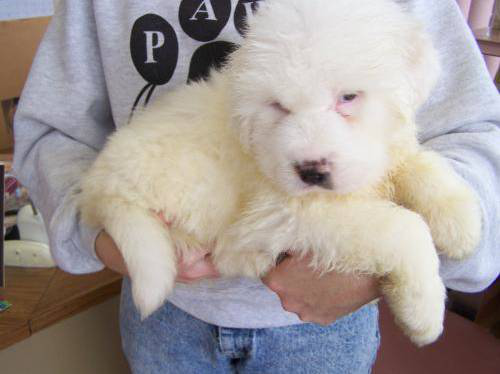

In [3]:
dog_path = os.path.join(TRAIN_DATA, 'dog')
dog_pictures = os.listdir(dog_path)
sampled_dog_image = np.random.choice(dog_pictures)
Image.open(os.path.join(dog_path, sampled_dog_image))

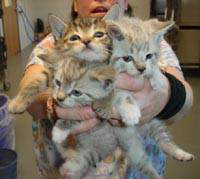

In [4]:
cat_path = os.path.join(TRAIN_DATA, 'cat')
cat_pictures = os.listdir(cat_path)
sampled_cat_image = os.path.join(cat_path, np.random.choice(cat_pictures))
Image.open(sampled_cat_image)

When training a deep net on a small amount of data, it is often beneficial to sample augmentations of the data. This effectively multiplies the amount of data you have to train on. To do this, we'll use Keras' `ImageDataGenerator` class. 

Note that this class isn't actually a generator, but instead follows the factory design pattern and is used to create generators.

First, let's look at how this works on the cat image we previewed earlier.

In [5]:
# These parameters control the range of augmentation we'll use.
generator_factory = ImageDataGenerator(
        rotation_range=10, 
        width_shift_range=0.2,
        height_shift_range=0.2,            
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [6]:
preview_dir = 'preview'
if not os.path.exists(preview_dir):
    os.mkdir(preview_dir)

In [7]:
img = load_img(sampled_cat_image, target_size=(IMG_HEIGHT, IMG_WIDTH))
img = np.expand_dims(img, axis=0)
# the `flow` method creates a generator that yields batches of images
img_generator = generator_factory.flow(img, batch_size=1, save_to_dir=preview_dir, save_format='jpg')

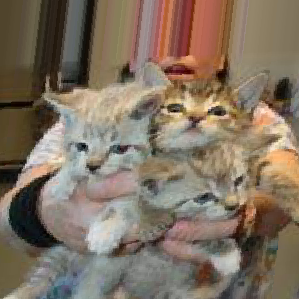

In [8]:
sampled_transformed_img = next(img_generator)
sampled_transformed_img = np.squeeze(sampled_transformed_img, axis=0)
sampled_transformed_img = array_to_img(sampled_transformed_img)
sampled_transformed_img

Now that we have a way to generate augmented images from our dataset, let's look at how we'll model this problem.

## What is Transfer Learning?

Transfer learning is when a model trained on one task is "transfered", or adjusted, to a new task. In our case, we'll be starting with a convnet pre-trained on the ImageNet dataset and transfering it to our cat/dog classification task.

Starting with a pre-trained model makes training take less time and fewer examples.

To do transfer learning on such a small dataset, we will freeze all of the layers in our pre-trained Inception v3 convnet so that they won't be updated. These layers already do a great job of extracting relevant features, and training them on a small dataset like this is more likely to cause harm than to help.

In [9]:
def setup_model():
    # Load up the pretrained Inception v3 model.
    img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))  # 3 color channels for red, green, and blue
    inception = InceptionV3(include_top=False, input_tensor=img)
    
    # Freezing the layers
    # For cat/dog classifier, we'll freeze all the layers. If you have more data and/or your problem is very 
    # different from the original task, you should experiment with leaving some of the later layers unfrozen.
    for layer in inception.layers:
        layer.trainable = False
        # Batch norm layers have parameters that get updated regardless of the `trainable` property state. 
        # Setting `momentum` to 1.0 prevents those updates from happening.
        if type(layer) == 'BatchNormalization':
            layer.momentum = 1.0
    
    # The last hidden layer has 8x8 spatial dimensions (downsampled from 299x299) and 2048 channels.
    # We'll average everything spatially to get a 2048D descriptor for the entire image.
    features = GlobalAveragePooling2D()(inception.layers[-1].output)
    
    # This 2048D descriptor is now the features we'll use to train a single layer.
    # More layers can be added here if you have enough data.
    classifier = Dense(2, activation='softmax')(features)
    model = Model(inputs=img, outputs=classifier)
    return model

In [10]:
model = setup_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Now, let's set up new data generators for training and validation data that also apply the same image preprocessing function that was used to train this Inception v3 model on ImageNet.

In [11]:
def setup_generator(data_dir):
    generator_factory = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.2,
            height_shift_range=0.2,                                   
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=preprocess_input)
    
    generator = generator_factory.flow_from_directory(
            data_dir, 
            target_size=(IMG_HEIGHT, IMG_WIDTH))
    return generator

In [12]:
train_generator = setup_generator(TRAIN_DATA)
val_generator = setup_generator(VAL_DATA)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [13]:
train_history = model.fit_generator(
        train_generator, 
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=VALIDATION_STEPS)

Epoch 1/5
50/50 [==============================] - 29s 575ms/step - loss: 0.3458 - acc: 0.8618 - val_loss: 0.1175 - val_acc: 0.9814
Epoch 2/5
50/50 [==============================] - 27s 533ms/step - loss: 0.1713 - acc: 0.9381 - val_loss: 0.1083 - val_acc: 0.9645
Epoch 3/5
50/50 [==============================] - 25s 506ms/step - loss: 0.1409 - acc: 0.9531 - val_loss: 0.1274 - val_acc: 0.9476
Epoch 4/5
50/50 [==============================] - 24s 483ms/step - loss: 0.1155 - acc: 0.9606 - val_loss: 0.0997 - val_acc: 0.9679
Epoch 5/5
50/50 [==============================] - 24s 480ms/step - loss: 0.1188 - acc: 0.9575 - val_loss: 0.1041 - val_acc: 0.9628


This takes roughly 10 minutes per epoch on a laptop. In practice, you are far better off using a GPU for a problem like this. For comparison, running this on a machine with a GPU takes 30 seconds per epoch. The rule of thumb here is that if you're using convolutions in your network, then you should be using a GPU if at all possible.

In [14]:
def undo_image_preprocessing(img):
    x = img / 2.
    x += 0.5
    x *= 255.
    return x

def sample_image_and_label(generator):
    """Sample image and label

    Returns both the preprocessed image data and the unprocessed image
    to make it easy to view and run predictions."""
    image_batch, label_batch = next(generator)
    test_img_data, test_label = image_batch[0], label_batch[0]

    test_img = undo_image_preprocessing(test_img_data)
    test_img = test_img.astype(np.uint8)
    test_img = Image.fromarray(test_img, mode='RGB')
    
    test_img_data = np.expand_dims(test_img_data, axis=0)

    return test_img_data, test_img, test_label

label: 1 prediction: 1


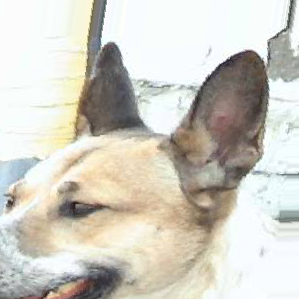

In [15]:
test_img_data, test_img, test_label = sample_image_and_label(val_generator)

prediction = model.predict(test_img_data)
print 'label:', np.argmax(test_label), 'prediction:', np.argmax(prediction)
print '=' * 22

test_img